In [2]:
install.packages('cowplot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [12]:
library(tidyverse)
library(tidymodels)
library(cowplot)

## Data Wrangling

First, we need to read the data and clean it before we can use the data. We can remove any NA values and add column names for readability.

In [13]:
#Read the data from the webpage into Jupyter
heart_disease <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
#Add column names based on the information given by the dataset webpage (to improve readability)
colnames(heart_disease) <- c("age", "sex", "chest_pain_type", "resting_blood_pressure", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "ST_level", "slope", "number_of_major_vessels", "thal", "diagnosis_of_heart_disease")
#Select chosen predictor and class variables 
heart_data <- heart_disease |> mutate(diagnosis = as_factor(diagnosis_of_heart_disease)) |> select(age, resting_blood_pressure, chol, ST_level, diagnosis)
#Check to see if there are any NA values
which(is.na(heart_data))
    #There aren't any NA values (the function returned no positions with missing values)

head(heart_data, n =8)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


integer(0)

age,resting_blood_pressure,chol,ST_level,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,2.3,0
67,160,286,1.5,2
67,120,229,2.6,1
37,130,250,3.5,0
41,130,204,1.4,0
56,120,236,0.8,0
62,140,268,3.6,3
57,120,354,0.6,0


Since we plan on doing classification of 2 categories, we can change all non-zero values of diagnosis into $1$ to indicate that heart disease is present. Afterwards, we can split it into training and testing datasets.

In [14]:
#Setting the seed to make results of the model reproducible and reusable
set.seed(2022)
#Assign all values, 1-4, as "1" to indicate that there is a heart disease
heart_data["diagnosis"][heart_data["diagnosis"] == "2"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "3"] <- "1"
heart_data["diagnosis"][heart_data["diagnosis"] == "4"] <- "1"
    #Source for code: https://www.statology.org/replace-values-in-data-frame-r/
#Split data into training and testing data; 75:25 split was chosen arbitrarily
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

For our exploratory data analysis, we can summarize our training data to see the number of observations for each category as well as the means of the predictors.

In [15]:
#Find the number of observations for each class (heart disease = 1 or no heart disease = 0) as well as the mean of each predictor
heart_summary <- heart_train |> group_by(diagnosis) |> summarize(number_of_observations = n(), mean_bp = mean(resting_blood_pressure), mean_chol = mean(chol), mean_st = mean(ST_level))
heart_summary

diagnosis,number_of_observations,mean_bp,mean_chol,mean_st
<fct>,<int>,<dbl>,<dbl>,<dbl>
0,123,129.5691,239.9187,0.601626
1,104,133.6058,250.9135,1.523077


From this table, we see that the number of observations for each diagnosis are roughly equal, meaning that KNN classification would work well. There also appears to be a difference between means of predictors for each category.

We can visualize the distributions of each predictor by plotting histograms and grouping by diagnosis

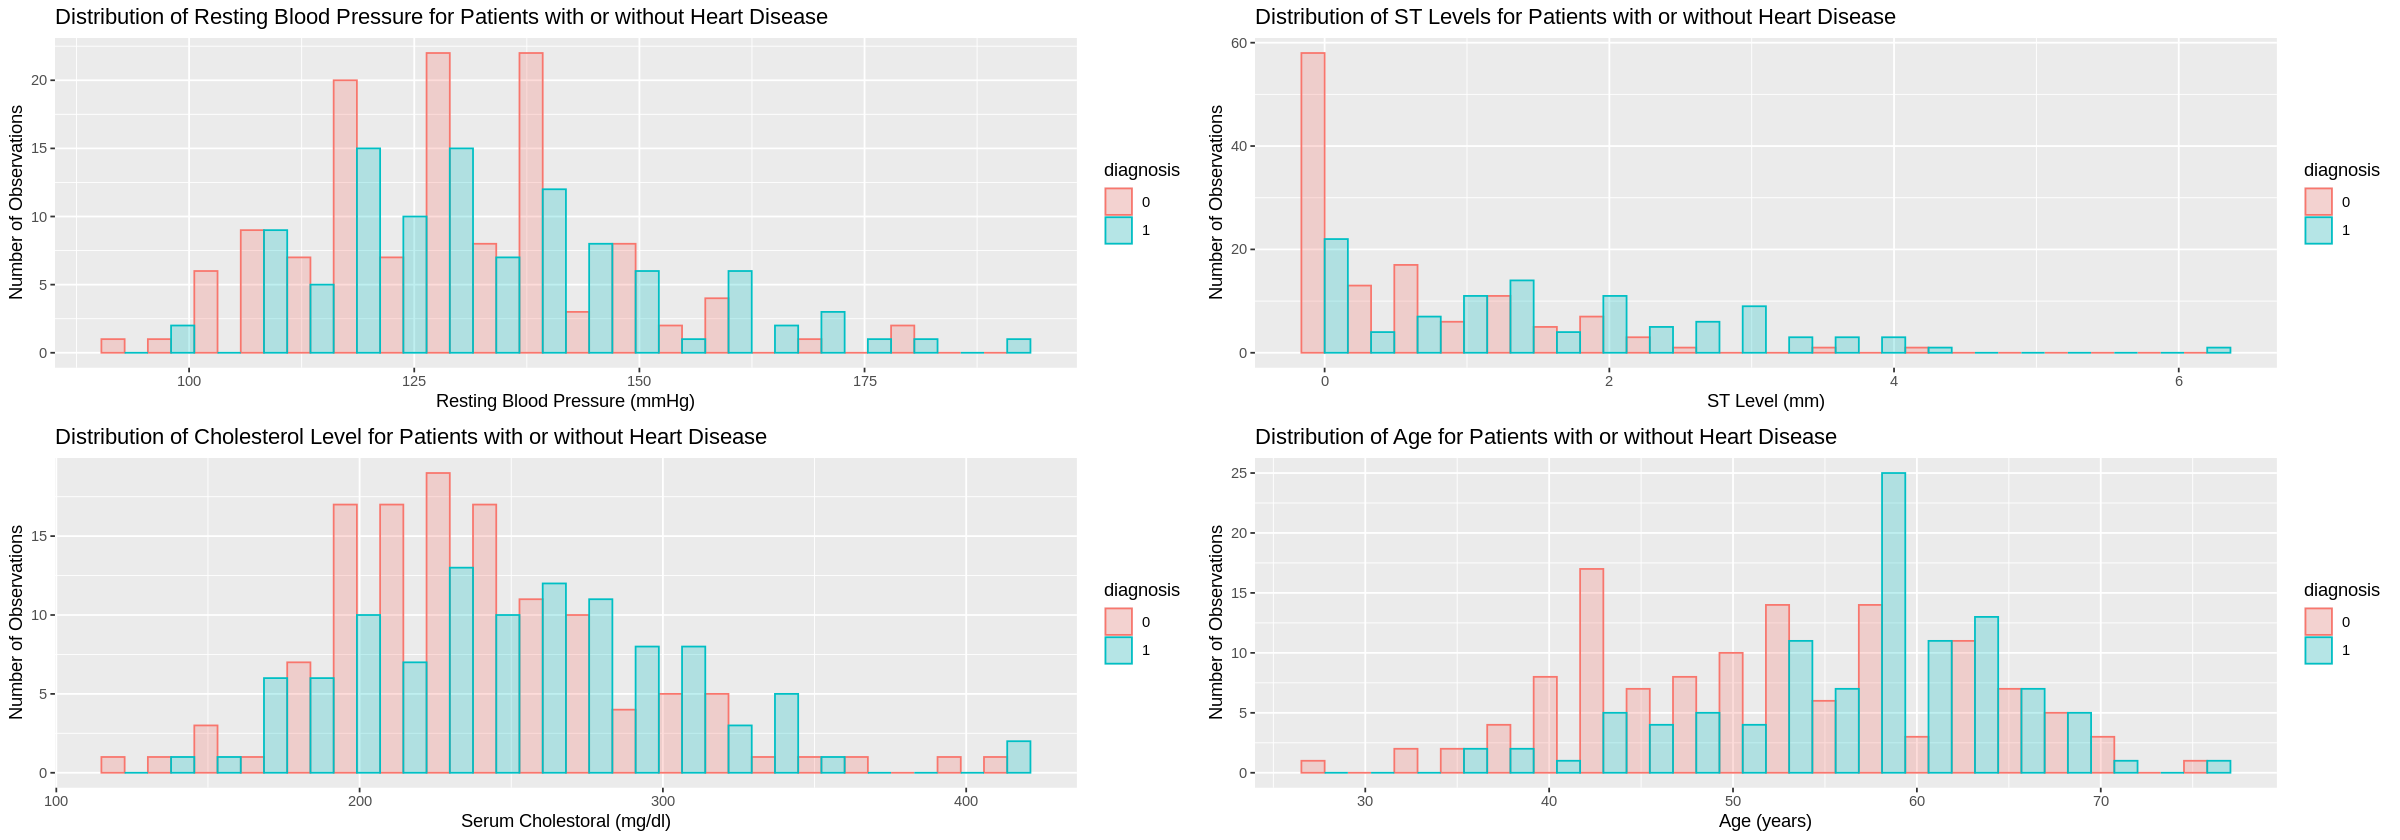

In [18]:
options(repr.plot.width = 20)
bp_distribution <- ggplot(heart_train, aes(x = resting_blood_pressure, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25, position =position_dodge()) + labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Observations") + ggtitle("Distribution of Resting Blood Pressure for Patients with or without Heart Disease")
                     
chol_distribution <- ggplot(heart_train, aes(x = chol, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25, position =position_dodge()) + labs(x ="Serum Cholestoral (mg/dl)", y = "Number of Observations") +  ggtitle("Distribution of Cholesterol Level for Patients with or without Heart Disease")

age_distribution <- ggplot(heart_train, aes(x = age, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20,alpha = 0.25, position =position_dodge()) + labs(x= "Age (years)", y = "Number of Observations") + ggtitle("Distribution of Age for Patients with or without Heart Disease") 

st_distribution <- ggplot(heart_train, aes(x = ST_level, fill = diagnosis, colour = diagnosis)) + geom_histogram(bins = 20, alpha = 0.25, position =position_dodge()) + labs(x = "ST Level (mm)", y = "Number of Observations") + ggtitle("Distribution of ST Levels for Patients with or without Heart Disease")

#NEED TO MAKE DIMENSIONS BIGGER + ADD TITLES
plot_grid(bp_distribution, st_distribution, chol_distribution, age_distribution)


In these plots, we can see that the prevalence of patients with heart disease increases as the resting blood pressure, ST levels and age increases. For example, patients with ST level higher than 3 are almost always going to have heart disease, and patients with resting blood pressure above 160 mmHg or are older than 55 years old are more likely to be diagnosed with heart disease. However, there seems to be no distinct relationship between cholesterol and heart disease (i.e., the distribution trend for patients with heart disease and patients without are similar). Therefore, we decided to exclude cholesterol from one of our predictors.

## Model Building & Choosing Best K

We want to create a KNN model which can classify heart diagnosis based on the three predictors above. First, we need to identify the best $k$ value which will give us the most accurate results. To do that, we create a tuning model with `tune()` as well as a recipe to fit that model to our training data. We need to set a seed to ensure reproducibility of our code.

In [23]:
set.seed(2023)
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")
knn_recipe <- recipe(diagnosis~ST_level+resting_blood_pressure+age, data = heart_train) |> step_scale(all_predictors()) |> step_center(all_predictors())

Now, we use cross-validation with our training data to find the $k$ value which has the highest accuracy. We tested 20 values of $k$, from 1 to 20, and obtained a dataframe with the accuracy of each $k$ value.

In [24]:
#Create folds (10 folds was chosen arbitrarily)
data_fold <- vfold_cv(heart_train, v = 10, strata = diagnosis)
k_values<-tibble(neighbors=seq(from=1, to=20, by=2))
#Fit with model to create table of k-values and accuracies
best_k <- workflow() |> add_model(knn_spec_tune) |> add_recipe(knn_recipe) |> tune_grid(data_fold, grid = k_values) |> collect_metrics()
head(best_k)

! Fold01: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold03: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold07: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5947958,10,0.02344506,Preprocessor1_Model01
1,roc_auc,hand_till,0.5898660,10,0.02405466,Preprocessor1_Model01
3,accuracy,multiclass,0.5995553,10,0.03584433,Preprocessor1_Model02
3,roc_auc,hand_till,0.6200146,10,0.03832038,Preprocessor1_Model02
5,accuracy,multiclass,0.6440382,10,0.03555387,Preprocessor1_Model03
5,roc_auc,hand_till,0.6614744,10,0.03580670,Preprocessor1_Model03


We can graph the accuracy of each $k$ value to determine the $k$ value with the highest accuracy.

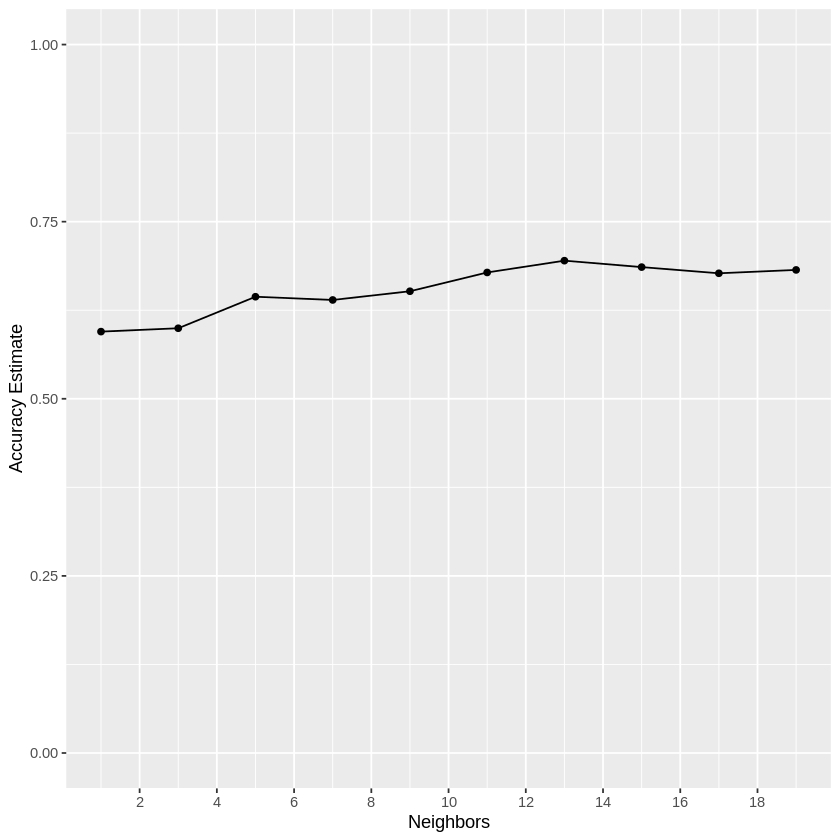

In [25]:
#we choose the best k parameter
accuracy_plot <- best_k |> filter(.metric == "accuracy") |> ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() + labs(x = "Neighbors", y = "Accuracy Estimate") +
     scale_x_continuous(breaks = seq(0, 20, by = 2)) + 
     scale_y_continuous(limits = c(0, 1.0))
accuracy_plot

From the graph, we see that `k = 13` produces the highest accuracy, but we double check to make sure:

In [26]:
#Find the k value with the maximum accuracy
k_model<-best_k|>filter(.metric=='accuracy')|>filter(mean==max(mean))|>select(neighbors)|>pull()
k_model

[1] 13

Finally, we can make a final model using the best k-value.

In [27]:
#Now we make the final model with k = 15
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_model) |> set_engine("kknn") |> set_mode("classification")
knn_recipe <- recipe(diagnosis~ST_level+resting_blood_pressure+age, data = heart_train) |> step_scale(all_predictors()) |> step_center(all_predictors())
knn_fit <- workflow() |> add_model(knn_spec) |> add_recipe(knn_recipe) |> fit(heart_train)

## Model Evaluation

We can evaluate the accuracy of our model using `predict()` on our testing data.

In [ ]:
prediction <- predict(knn_fit, heart_test) |> bind_cols(heart_test)
accuracy <- metrics(prediction, truth = diagnosis, estimate = .pred_class)|>filter(.metric=='accuracy')
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7236842


Our model has an accuracy of 72%.

## Visualizing Results

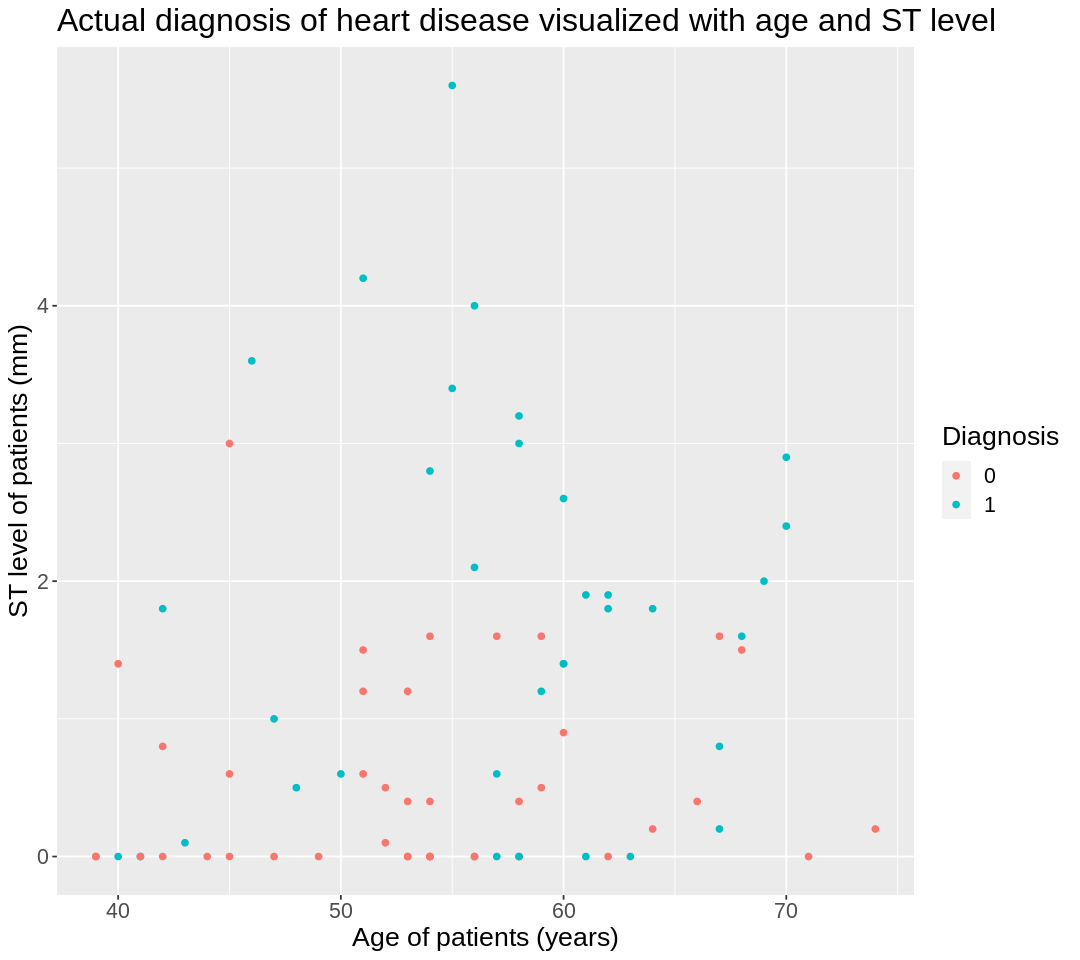

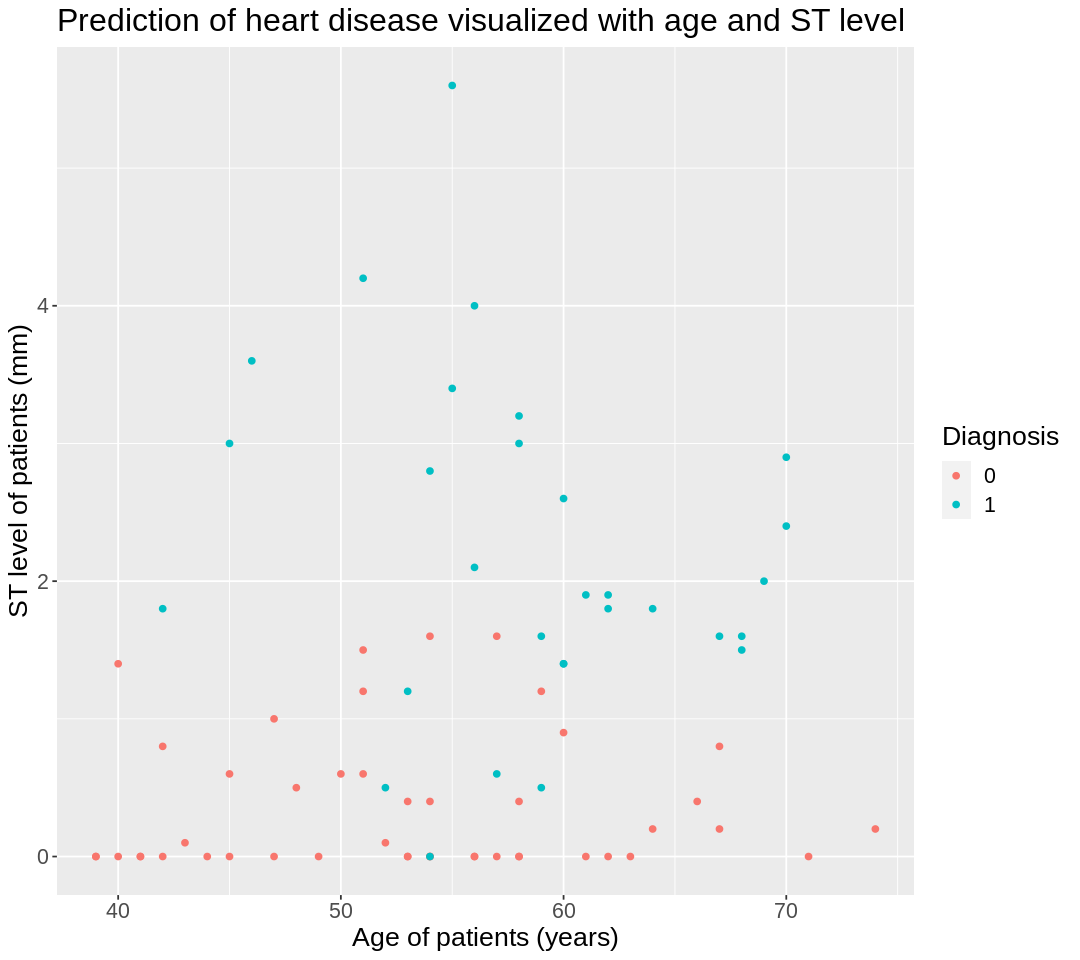

In [13]:
#Comparing the prediction for the diagnosis and the actual diagnosis
options(repr.plot.width = 9, repr.plot.height = 8)
prediction_plot_age_ST<-prediction|>
ggplot(aes(x=age, y=ST_level, colour=.pred_class))+
    geom_point()+
       labs(x='Age of patients (years)', y='ST level of patients (mm)', colour='Diagnosis')+
ggtitle('Prediction of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))


testing_plot_age_ST<-prediction|>
ggplot(aes(x=age, y=ST_level, colour=diagnosis))+
geom_point()+
labs(x='Age of patients (years)', y='ST level of patients (mm)', colour='Diagnosis')+
ggtitle('Actual diagnosis of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))
testing_plot_age_ST
prediction_plot_age_ST

As we can see from the scatterplots above, the prediction of the models are similar to the actual diagnosis
of the patients.

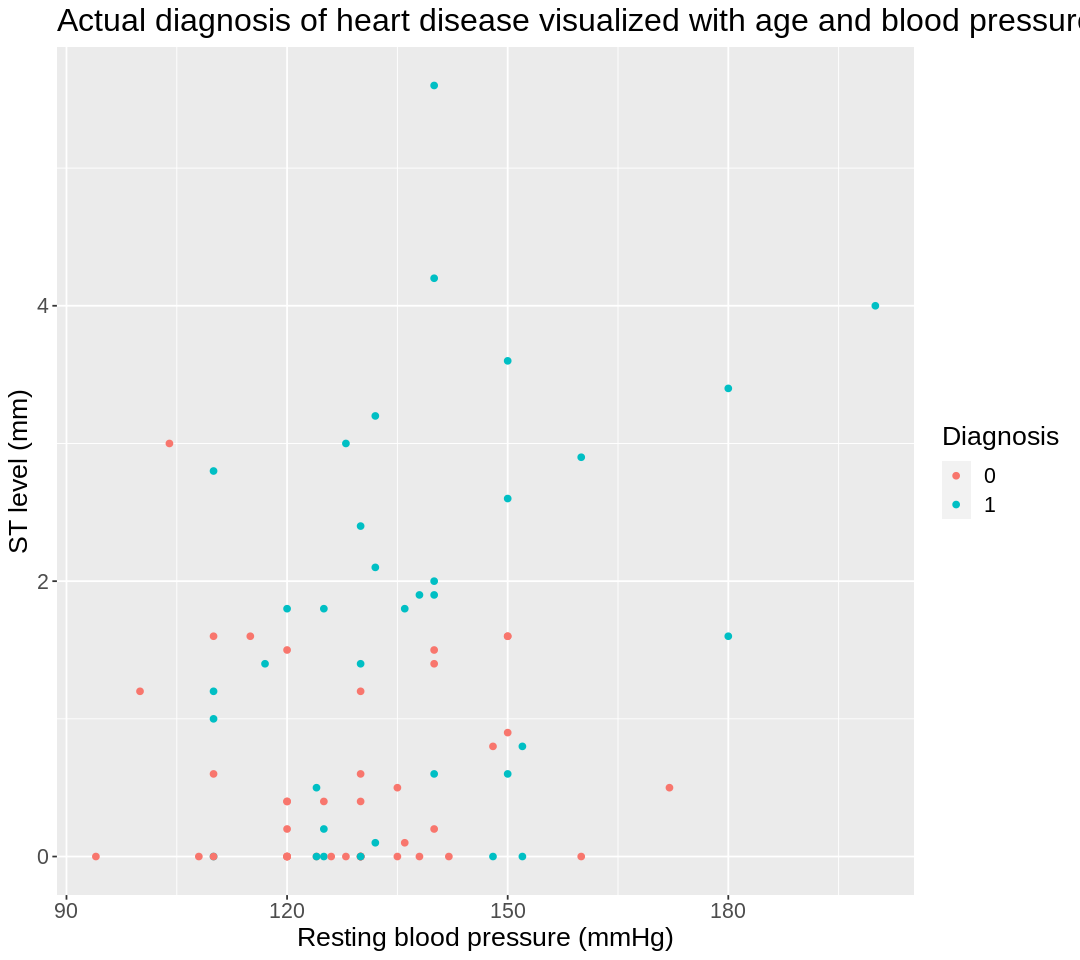

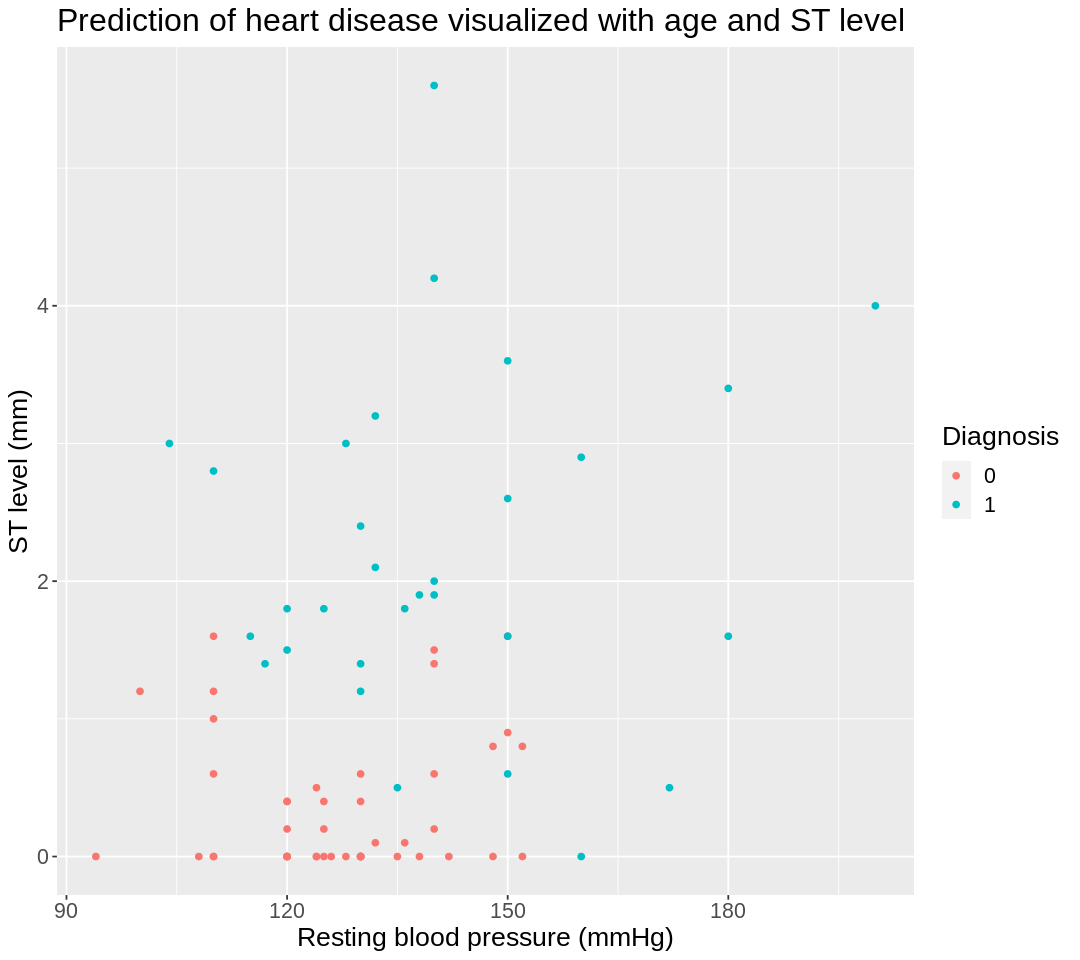

In [14]:
options(repr.plot.width = 9, repr.plot.height = 8)
prediction_plot_st_bp<-prediction|>
ggplot(aes(x=resting_blood_pressure, y=ST_level, colour=.pred_class))+
    geom_point()+
       labs(y='ST level (mm)', x='Resting blood pressure (mmHg)', colour='Diagnosis')+
ggtitle('Prediction of heart disease visualized with age and ST level')+
theme(text=element_text(size=16))


testing_plot_st_bp<-prediction|>
ggplot(aes(y=ST_level, x=resting_blood_pressure, colour=diagnosis))+
geom_point()+
labs(y='ST level (mm)', x='Resting blood pressure (mmHg)', colour='Diagnosis')+
ggtitle('Actual diagnosis of heart disease visualized with age and blood pressure')+
theme(text=element_text(size=16))
testing_plot_st_bp
prediction_plot_st_bp

Again from these two graphs, we can see that the model's predictions yield a similar distribution of 
patients with heart disease to that of the actual diagnosis.

Another takeaway that can be made from the two comparisons that were made is that the model appears to be much better at predicting the diagnosis of a patient when the ST level is really high (>2mm). As was stated earlier, the ST level is the predictor that has the strongest relationship with the prevalence of heart disease.